## 0.  Import Libraries

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import datetime

## 1. Open Data

In [16]:
# opening sample data
data = xr.open_dataset(fr'data/TOT_PREC/data_06.nc')['tp'] * 1e3

In [17]:
# for every data do this regardless of the season
data[0] = data[1]

# only for winter do this
# data[12.ay'ın ilk gününün 00 UTC si] = data[12.ay'ın ilk gününün 01 UTC si]

In [18]:
data['time'].dt.hour

<xarray.DataArray 'hour' (time: 744)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,
...
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Coordinates:
  * time     (time) datetime64[ns] 1985-07-01 ... 1985-07-31T23:00:00

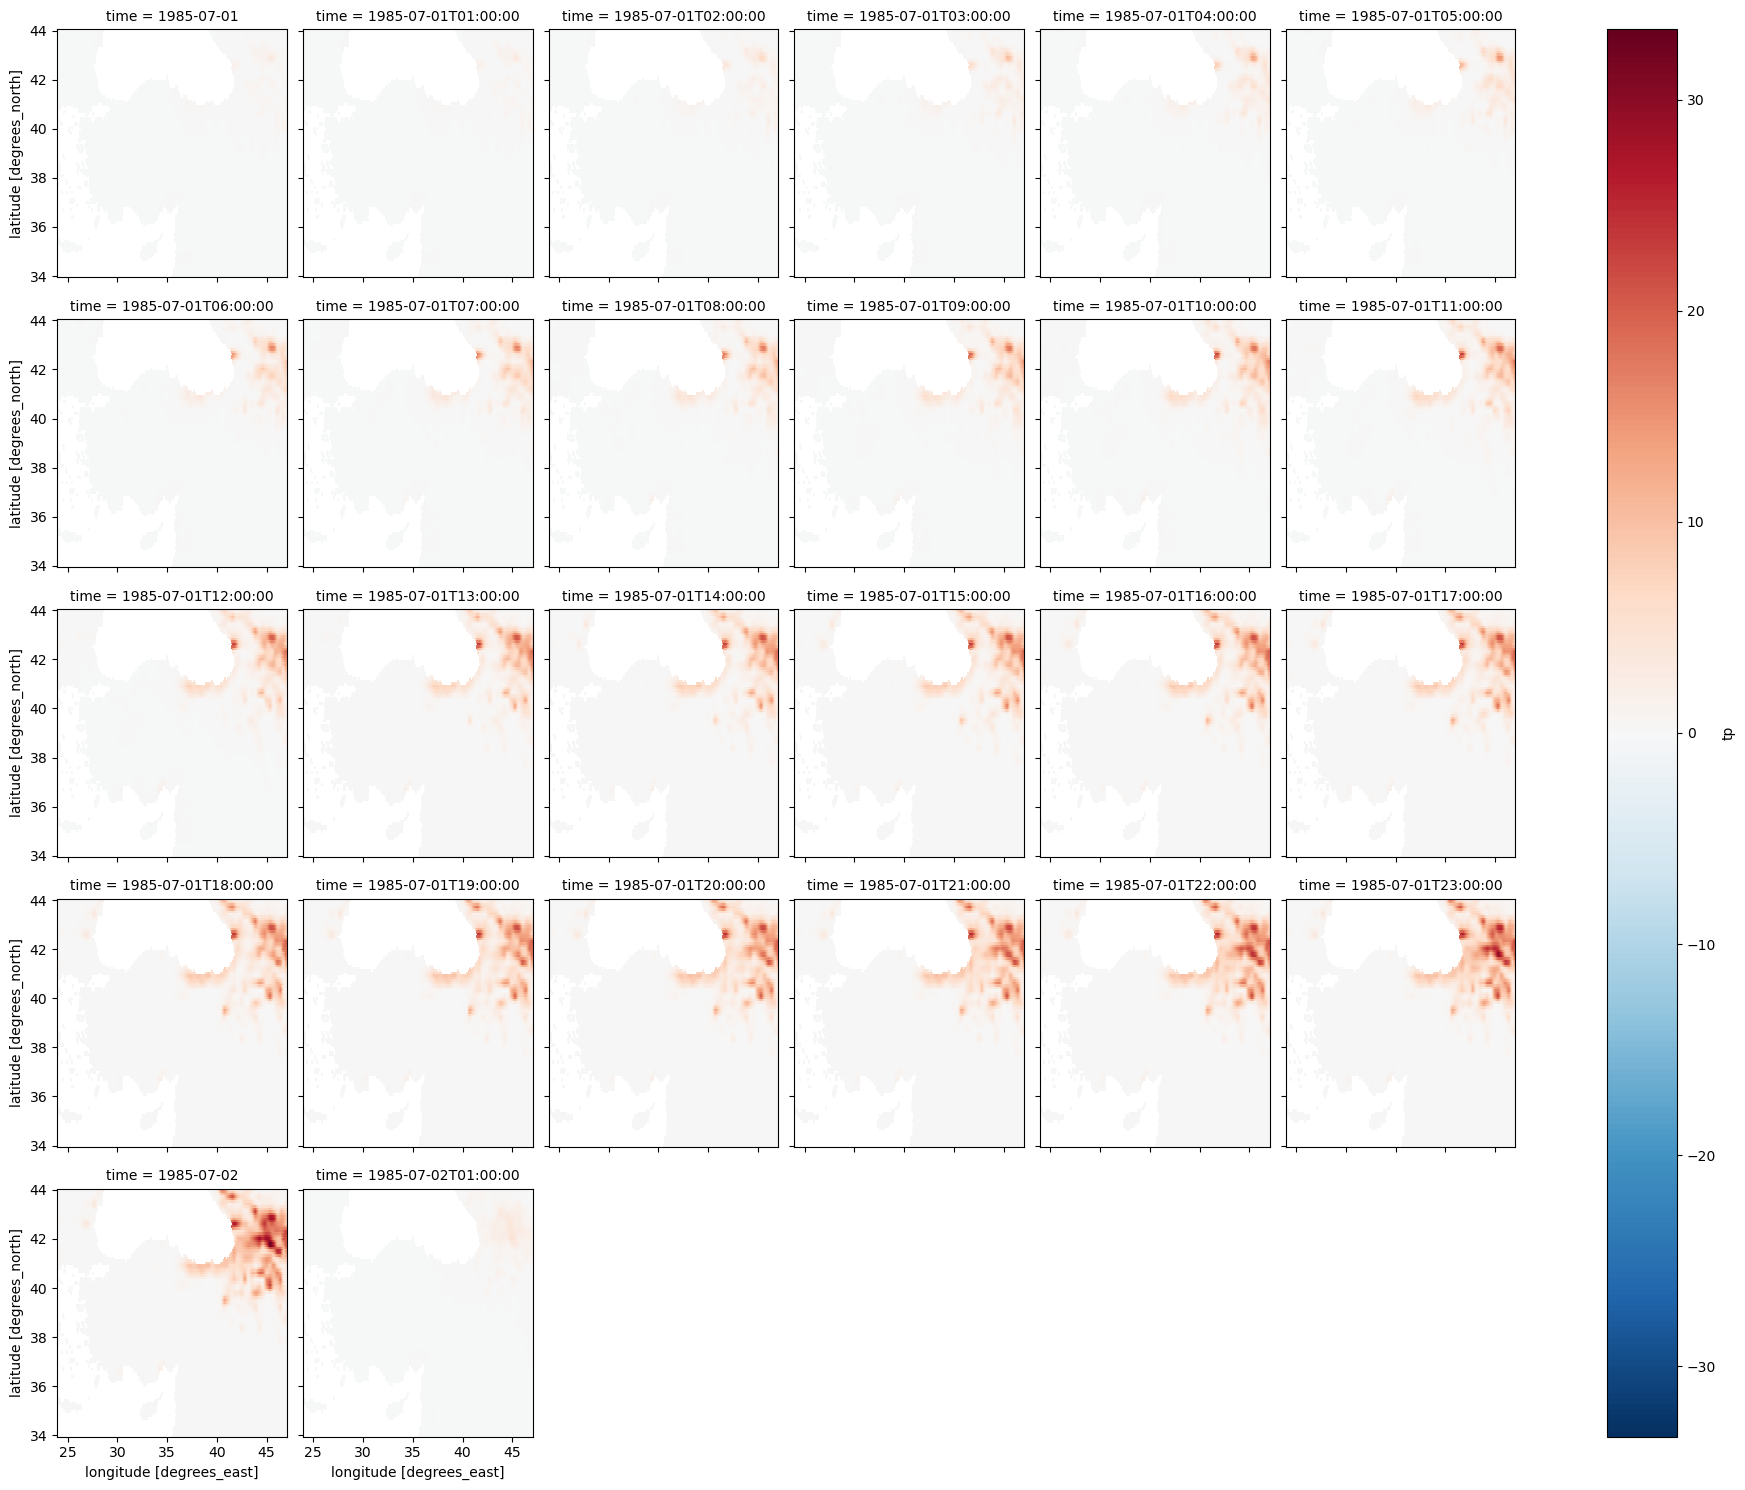

In [19]:
data[0:26].plot.pcolormesh(col='time', col_wrap=6)

In [20]:
season = 'winter'

# do not change base data
data_adjust = data.copy(deep=True)

for i, h in enumerate(data['time'].dt.hour): # sample for first 26 data
    
    # integer h
    h_int = int(h.values)
    
    # do not change initial data hour
    if i == 0:
        continue
        
    # do not change initial data hour of 12. month for winter
    if season == 'winter':
        if i == 10287: # 12.ay'ın ilk gününün 00 UTC si
            continue # we have already checked and changed it above!!
    
    # 01 UTC is clear
    if h_int == 1:
        continue
    # other than 01 UTC
    else:
        data_adjust[i] = data[i] - data[i-1]

In [21]:
data_adjust.max() # mm

<xarray.DataArray 'tp' ()>
array(10.95664215)

In [71]:
data_adjust.min()

<xarray.DataArray 'tp' ()>
array(-0.00138211)

## 2. Merge Data and Check Adjustment

dont forget, you first merge each year individually and save, then you will merge all years together

### 2.1 Winter

In [77]:
# for winter
season = 'winter'
# opening sample data
datasets = [fr'data/TOT_PREC/data_01.nc',
            fr'data/TOT_PREC/data_02.nc',
            fr'data/TOT_PREC/data_12.nc']

# open data
data = xr.open_mfdataset(datasets)['tp'] * 1e3

# get times and year list
times = data['time'].values
year = data['time'].dt.year.values[0]

# for every data do this regardless of the season
data[0] = data[1]

# only for winter do this
if season == 'winter':
    
    # find where 12. month starts
    winter_december_idx = np.argwhere(times == np.datetime64(fr'{year}-12-01T00:00:00.000000000')).flatten()[0]
    # data[12.ay'ın ilk gününün 00 UTC si] = data[12.ay'ın ilk gününün 01 UTC si]
    data[winter_december_idx] = data[winter_december_idx+1]

In [78]:
winter_december_idx

1416

In [71]:
# do not change base data
data_adjust = data.copy(deep=True)

for i, h in enumerate(data['time'].dt.hour): # sample for first 26 data
    
    # integer h
    h_int = int(h.values)
    
    # do not change initial data hour
    if i == 0:
        continue
        
    # do not change initial data hour of 12. month for winter
    if season == 'winter':
        if i == winter_december_idx: # 12.ay'ın ilk gününün 00 UTC si
            continue # we have already checked and changed it above!!
    
    # 01 UTC is clear
    if h_int == 1:
        continue
    # other than 01 UTC
    else:
        data_adjust[i] = data[i] - data[i-1]

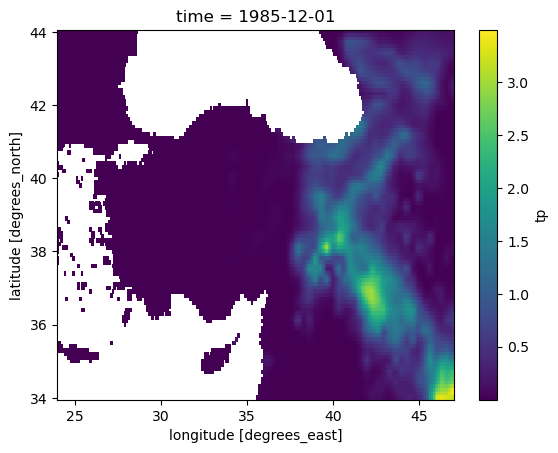

In [75]:
data_adjust[winter_december_idx].plot()

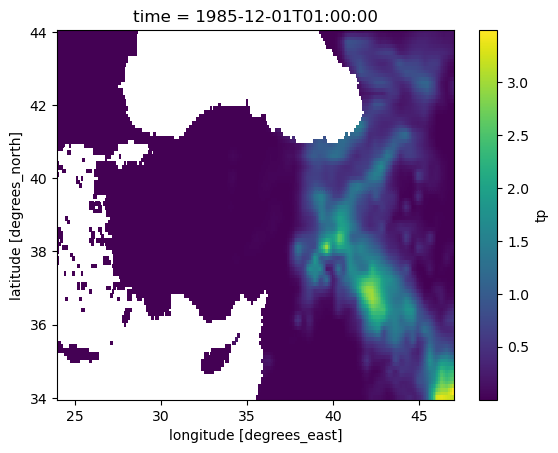

In [76]:
data_adjust[winter_december_idx+1].plot()